In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

get_session()

In [4]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
np.where(y_test.flatten() == 4)[0][0]

22

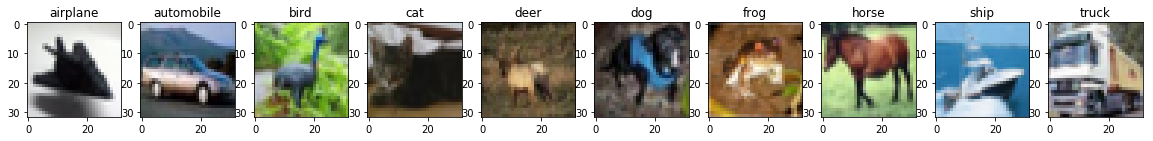

In [7]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord][0]])

plt.show()

In [8]:
model = keras.models.load_model('./cifar10.h5')

5 0.97384477
[5]


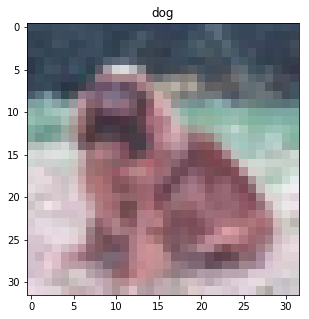

In [9]:
idx = 101
result_idx = model.predict_on_batch(x_test[idx][np.newaxis,...]/255).argmax()
print(result_idx, model.predict_on_batch(x_test[idx][np.newaxis,...]/255)[0,result_idx])
print(y_test[idx])

plt.figure(figsize=(5,5))
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx][0]])
plt.show()

In [10]:
def VisualizeImageGrayscale(image_3d, percentile=99):
    image_2d = np.sum(np.abs(image_3d), axis=2)
    vmax = np.percentile(image_2d, percentile)
    vmin = np.min(image_2d)
    return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)

# Coherence

## Saliency map
$$
Saliency(x) := \bigtriangledown_xf(x) = \frac{\partial f(x)}{\partial x}
$$

In [11]:
from coherence import saliency

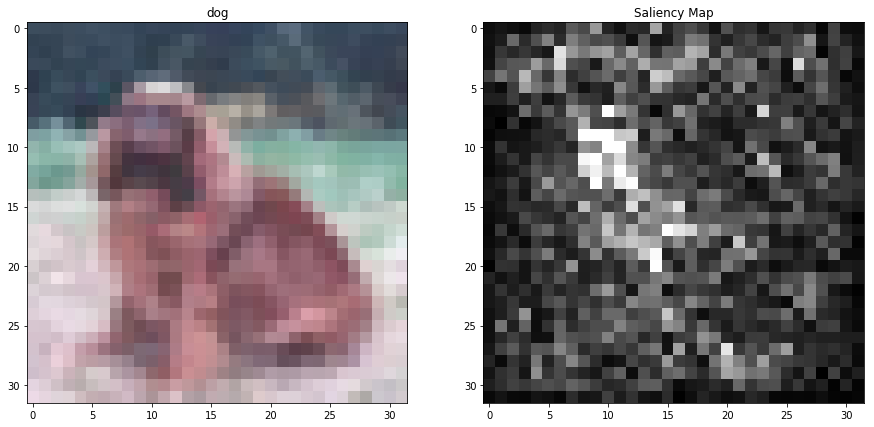

In [12]:
grads_orig = saliency(y_test[idx][0], model)
result = grads_orig([x_test[idx][np.newaxis,...]/255])[0][0]
s_map = VisualizeImageGrayscale(result)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx,0]])
plt.subplot(122)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.show()

## SmoothGrad
$$
\hat{M}_c(x) = \frac{1}{n}\sum^n_{k=1}M_c(x+\epsilon_k),\ \epsilon \sim \mathcal{N}(0, \sigma^2)
$$

In [27]:
from coherence import smoothgrad

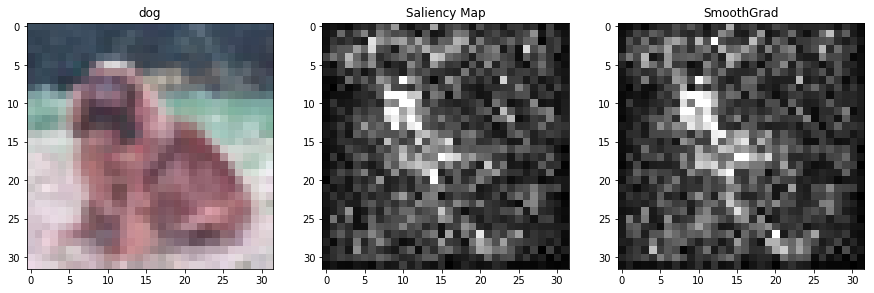

In [31]:
n = 10
sigma = .01

grads_output = smoothgrad(grads_orig, x_test[idx][np.newaxis,...].astype(np.float32)/255, n, sigma)
sgrad = VisualizeImageGrayscale(grads_output[0])

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx,0]])
plt.subplot(132)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(133)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.show()

## VarGrad
\begin{align}
    \tilde{M}_c(x) &= Var(M_c(x+\epsilon_k)) \\
    &= \frac{1}{n}\sum^n_{k=1}{M_c(x+\epsilon_k)}^2 - {\hat{M}_c(x)}^2
\end{align}

In [32]:
from coherence import vargrad

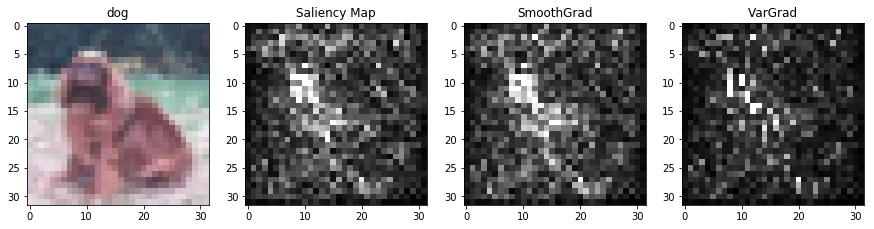

In [33]:
n = 10
sigma = .01

grads_output = vargrad(grads_orig, x_test[idx][np.newaxis,...].astype(np.float32)/255, n, sigma)
vgrad = VisualizeImageGrayscale(grads_output[0])

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx,0]])
plt.subplot(142)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(143)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.subplot(144)
plt.imshow(vgrad, 'gray')
plt.title('VarGrad')
plt.show()

## Integrated Gradients
\begin{align}
IntegratedGrads^{approx}_i(x) := (x_i-x'_i)\ \times\ \sum^m_{k=1}\frac{\partial F(x'+\frac{k}{m}\times(x-x'))}{\partial x_i}\ \times\ \frac{1}{m}
\end{align}

In [35]:
from coherence import integratedgrad

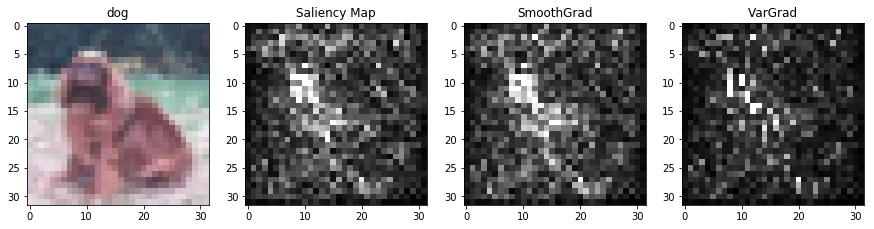

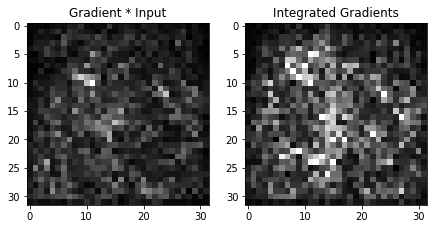

In [36]:
grads_output = integratedgrad(grads_orig, x_test[idx][np.newaxis,...].astype(np.float32)/255)
integrad = VisualizeImageGrayscale(grads_output[0])

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx,0]])
plt.subplot(142)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(143)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.subplot(144)
plt.imshow(vgrad, 'gray')
plt.title('VarGrad')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(141)
plot5 = np.abs((x_test[idx]/255)*result).mean(axis=-1)
plt.imshow(plot5, 'gray')
plt.title('Gradient * Input')
plt.subplot(142)
plt.imshow(integrad, 'gray')
plt.title('Integrated Gradients')
plt.show()

# Model

## basic model

In [43]:
from IPython.display import Image

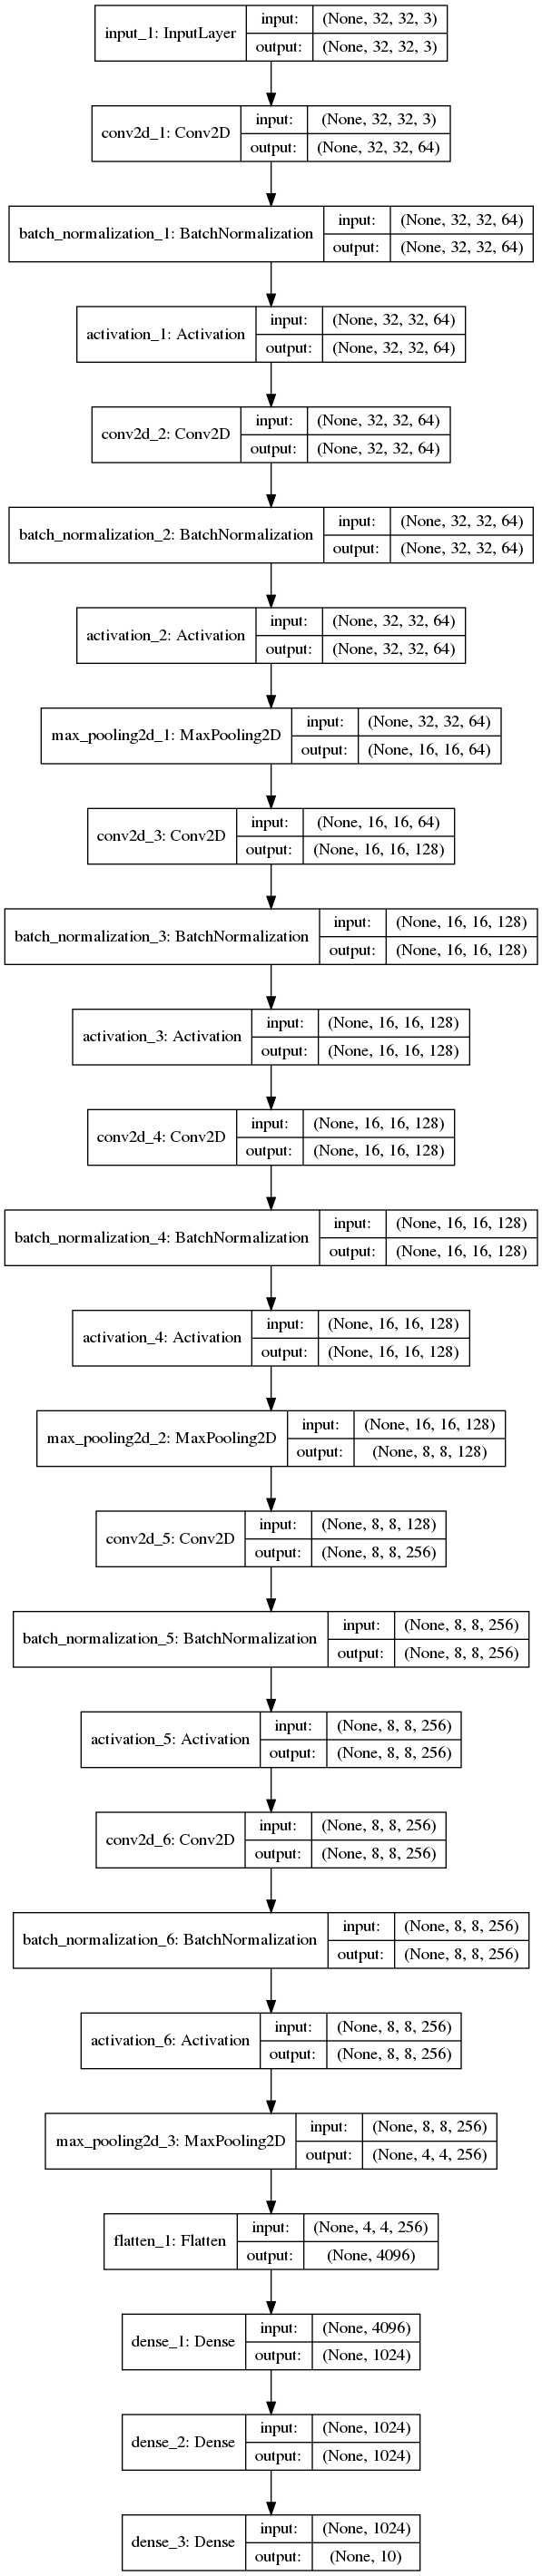

In [44]:
Image("img/model.png")

## Squeeze-Excitation

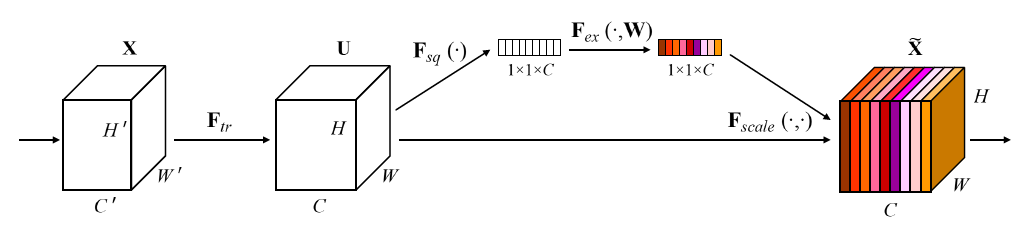

In [46]:
Image("img/senet.png")

## CBAM (Convolutional Block Attention Module)

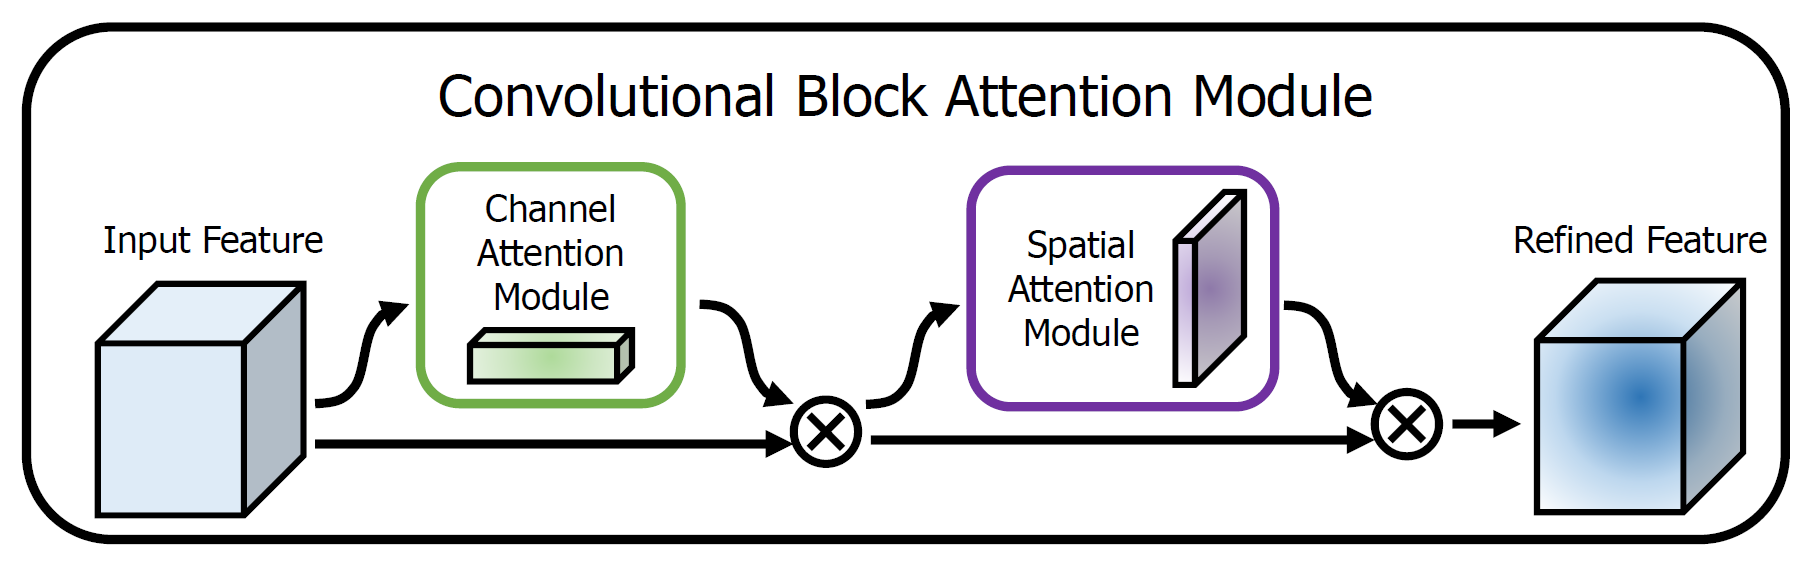

In [47]:
Image("img/cbam.png")

# results of ROAR

In [2]:
import pandas as pd

In [3]:
color = {'no': 'red',
         'seblock': 'green',
         'cbamblock': 'blue'}

linestyle = {'saliency': '-',
             'smoothgrad': '--',
             'smoothgrad2': '-.',
             'vargrad': ':'}

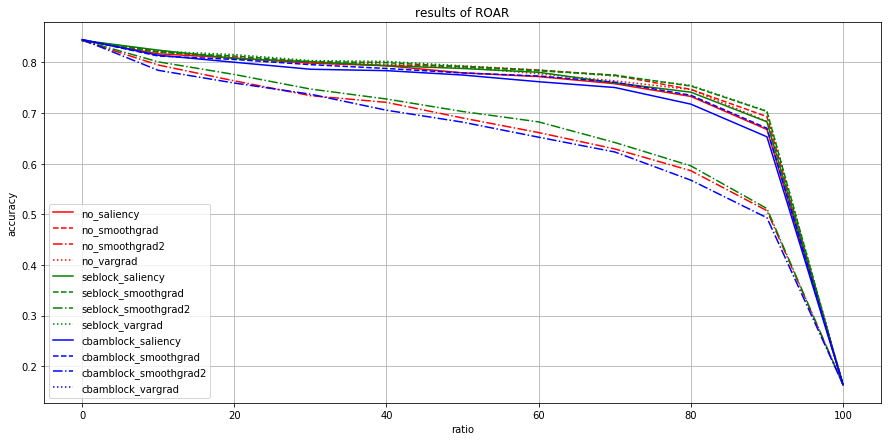

In [5]:
plt.figure(figsize=(15,7))
for model in ['no', 'seblock', 'cbamblock']:
    for coherence in ['saliency', 'smoothgrad', 'smoothgrad2', 'vargrad']:
        result = []
        df = pd.read_csv('./history/{}_.csv'.format(model))
        result.append(df['val_acc'].max())
        for ratio in range(1, 11):
            try:
                df = pd.read_csv('./history/ROAR_{}_{}_{}.csv'.format(model, coherence, int(ratio*10)))
                result.append(df['val_acc'].max())
            except:
                break
            
        plt.plot(np.arange(0, len(result)*10, 10), result, label='{}_{}'.format(model, coherence), color=color[model], linestyle=linestyle[coherence])

plt.grid()
plt.legend()
plt.xlabel('ratio')
plt.ylabel('accuracy')
plt.title('results of ROAR')
plt.show()